In [1]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from sklearn.datasets import make_moons
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.03, random_state=42)

In [3]:
import pandas as pd
moons = pd.DataFrame({"X1" : X[:,0],
                      "X2" : X[:,1],
                      "label": y})
moons[:5]

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0


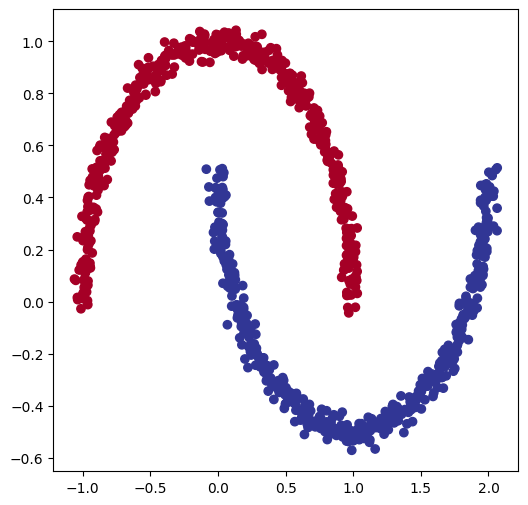

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(x=moons["X1"], y=moons["X2"], c = y, cmap=plt.cm.RdYlBu)

In [5]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


from sklearn.model_selection import train_test_split
X_train,X_test, y_train ,y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train),len(y_train)

(800, 800)

In [6]:
y.unique()

tensor([0., 1.])

In [7]:
class MoonModelV0(nn.Module):
    
    def __init__(self, input_feat, output_feat, hidden_layer):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features=input_feat, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=hidden_layer),
            nn.ReLU(),
            nn.Linear(in_features=hidden_layer, out_features=output_feat),
            nn.ReLU())
        
    def forward(self, x):
        return self.layer(x)


model = MoonModelV0(input_feat = 2,
                   output_feat= 1,
                   hidden_layer=10).to(device)

model

MoonModelV0(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): ReLU()
  )
)

In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.1)

In [9]:
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device)
acc_fn

2023-03-10 08:30:52.950584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 08:30:56.470906: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-10 08:30:56.471214: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-10 08:30:56.471234: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

MulticlassAccuracy()

In [10]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)
    
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_pred, y_train.int())

    optimizer.zero_grad()
        
    loss.backward()

    optimizer.step()

    model.eval() 
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred_probs = torch.sigmoid(test_logits)
        test_pred = torch.round(test_pred_probs)

        test_loss = loss_fn(test_logits, y_test)
        test_acc = acc_fn(test_pred, y_test.int())

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69 Acc: 0.59 | Test loss: 0.69 Test acc: 0.60
Epoch: 100 | Loss: 0.53 Acc: 0.81 | Test loss: 0.54 Test acc: 0.79
Epoch: 200 | Loss: 0.47 Acc: 0.87 | Test loss: 0.48 Test acc: 0.86
Epoch: 300 | Loss: 0.45 Acc: 0.89 | Test loss: 0.45 Test acc: 0.87
Epoch: 400 | Loss: 0.43 Acc: 0.91 | Test loss: 0.43 Test acc: 0.88
Epoch: 500 | Loss: 0.41 Acc: 0.93 | Test loss: 0.41 Test acc: 0.89
Epoch: 600 | Loss: 0.39 Acc: 0.94 | Test loss: 0.39 Test acc: 0.94
Epoch: 700 | Loss: 0.38 Acc: 0.96 | Test loss: 0.38 Test acc: 0.94
Epoch: 800 | Loss: 0.37 Acc: 0.97 | Test loss: 0.37 Test acc: 0.96
Epoch: 900 | Loss: 0.36 Acc: 0.98 | Test loss: 0.36 Test acc: 0.97


In [11]:
import numpy as np
# this function has copied from somewhere.
def plot_decision_boundary(model, X, y):
  
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), 
                         np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 
    else: 
        y_pred = torch.round(torch.sigmoid(y_logits)) 
    
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

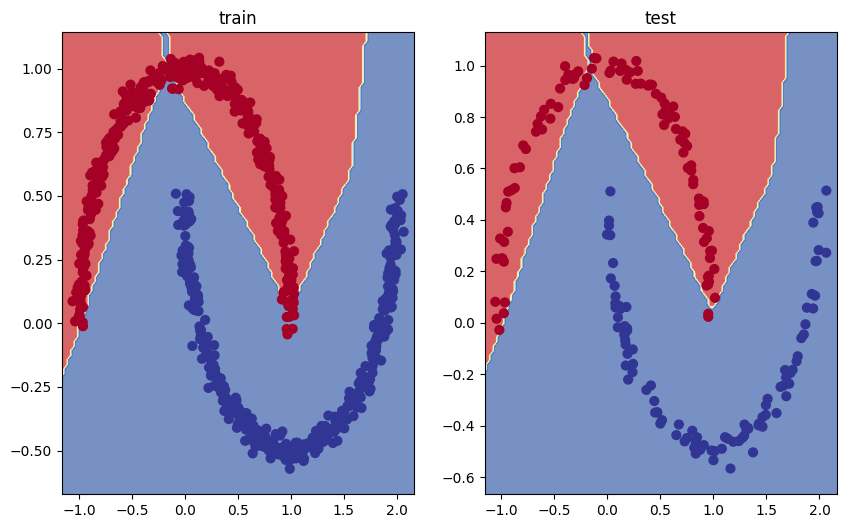

In [12]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model, X_test, y_test)